### **Import Libraries**

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress all logs except warnings

from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import (make_scorer, accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from interpret.glassbox import ExplainableBoostingClassifier
from ngboost import NGBClassifier
from snapml import BoostingMachineClassifier
from tab_transformer_pytorch import TabTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import lightgbm as lgb

from skopt import BayesSearchCV
from ray import tune
from ngboost.distns import Bernoulli
from ngboost.scores import LogScore
from sklearn.ensemble import StackingClassifier
import xgboost as xgb

from sklearn.base import BaseEstimator, ClassifierMixin

### **Load & Split Data**

In [2]:
df = pd.read_csv("../data/derived_data.csv")
df = df.iloc[:, 1:]

print('Sample Data')
display(df.head())

Sample Data


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,pulse_pressure,map,std_ratio,cardio
0,50,1,168,62.0,110,80,0,0,0,0,1,21.97,30,90.00,1.38,0
1,55,0,156,85.0,140,90,2,0,0,0,1,34.93,50,106.67,1.56,1
2,51,0,165,64.0,130,70,2,0,0,0,0,23.51,60,90.00,1.86,1
3,48,1,169,82.0,150,100,0,0,0,0,1,28.71,50,116.67,1.50,1
4,60,0,151,67.0,120,80,1,1,0,0,0,29.38,40,93.33,1.50,0


In [3]:
X = df.drop('cardio', axis=1)  
y = df['cardio']   

In [4]:
label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

### **Scaling Data**

In [5]:
standard_features = ['age', 'height', 'weight','ap_hi', 'ap_lo', 'bmi', 'pulse_pressure', 'map', 'std_ratio']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

assert all(feature in X.columns for feature in standard_features + categorical_features)

In [6]:
scaler_standard = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', scaler_standard, standard_features)
    ],
    remainder='passthrough'  # Leave categorical/binary features unchanged
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

X_preprocessed = pd.DataFrame(X_preprocessed, columns=standard_features + categorical_features)
X_preprocessed

,age,height,weight,ap_hi,ap_lo,bmi,pulse_pressure,map,std_ratio,gender,cholesterol,gluc,smoke,alco,active
0,-0.430687,0.441395,-0.868717,-1.155855,-0.231849,-1.050771,-1.417929,-0.733317,-1.335045,1.0,0.0,0.0,0.0,0.0,1.0
1,0.310810,-1.067843,0.760886,0.929802,1.064795,1.413813,0.493322,1.082298,0.076019,0.0,2.0,0.0,0.0,0.0,1.0
2,-0.282387,0.064086,-0.727012,0.234583,-1.528493,-0.757912,1.448948,-0.733317,2.427792,0.0,2.0,0.0,0.0,0.0,0.0
3,-0.727286,0.567165,0.548329,1.625020,2.361439,0.230965,0.493322,2.171449,-0.394336,1.0,0.0,0.0,0.0,0.0,1.0
4,1.052307,-1.696692,-0.514455,-0.460636,-0.231849,0.358377,-0.462303,-0.370629,-0.394336,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64464,0.607409,0.064086,0.406625,1.625020,-0.231849,0.358377,2.404573,0.718522,2.584577,0.0,0.0,0.0,0.0,0.0,1.0
64465,-0.134088,0.441395,0.123215,-0.460636,-0.231849,-0.107535,-0.462303,-0.370629,-0.394336,1.0,0.0,0.0,1.0,0.0,1.0
64466,1.200607,-0.816303,3.665832,0.929802,1.064795,4.369031,0.493322,1.082298,0.076019,0.0,1.0,1.0,0.0,0.0,1.0
64467,1.200607,-0.187454,-0.160194,0.582192,-0.231849,-0.075207,0.971135,0.173946,1.095120,0.0,0.0,1.0,0.0,0.0,0.0


### **Train, Val, Test**

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)  # Train 70%
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)  # Val 20%, Test 10%


In [8]:
# NumPy array format
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

### **Base Model**

#### **Explainable Boosting Machine (EBM)**

EBM Accuracy: 0.7245

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.71      0.77      0.74      3261
 Cardio Risk       0.74      0.68      0.71      3186

    accuracy                           0.72      6447
   macro avg       0.73      0.72      0.72      6447
weighted avg       0.73      0.72      0.72      6447



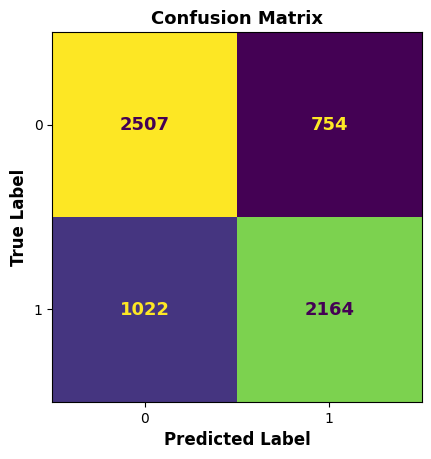

In [9]:
base_model_ebm = ExplainableBoostingClassifier()

base_model_ebm.fit(x_train, y_train)

y_pred = base_model_ebm.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"EBM Accuracy: {accuracy:.4f}")

report = classification_report(y_test, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_ebm.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

#### **NGBoost**

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5580 val_loss=0.0000 scale=2.0000 norm=3.7878
[iter 200] loss=0.5478 val_loss=0.0000 scale=2.0000 norm=3.8808
[iter 300] loss=0.5452 val_loss=0.0000 scale=1.0000 norm=1.9563
[iter 400] loss=0.5435 val_loss=0.0000 scale=1.0000 norm=1.9654
NGBClassifier Accuracy: 0.7228

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.71      0.77      0.74      3261
 Cardio Risk       0.74      0.67      0.71      3186

    accuracy                           0.72      6447
   macro avg       0.72      0.72      0.72      6447
weighted avg       0.72      0.72      0.72      6447



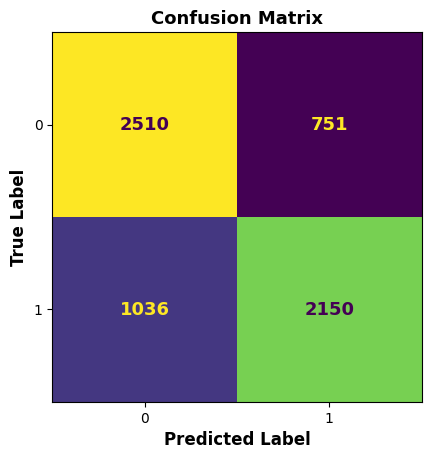

In [10]:
class NGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.ngb = NGBClassifier(**kwargs)
        self.classes_ = None

    def fit(self, X, y):
        self.ngb.fit(X, y)
        self.classes_ = np.unique(y)  # Define the classes explicitly
        return self

    def predict(self, X):
        return self.ngb.predict(X)

    def predict_proba(self, X):
        return self.ngb.predict_proba(X)

base_model_ngb = NGBClassifierWrapper(Dist=Bernoulli)

base_model_ngb.fit(x_train, y_train)

y_pred = base_model_ngb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"NGBClassifier Accuracy: {accuracy:.4f}")

report = classification_report(y_test, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_ngb.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

#### **SnapBoost**

SnapBoost Accuracy: 0.7214

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.71      0.77      0.74      3261
 Cardio Risk       0.74      0.67      0.70      3186

    accuracy                           0.72      6447
   macro avg       0.72      0.72      0.72      6447
weighted avg       0.72      0.72      0.72      6447



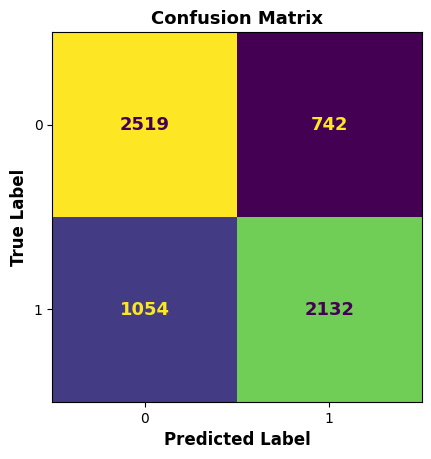

In [11]:
base_model_snb = BoostingMachineClassifier()

base_model_snb.fit(x_train_np, y_train_np)

y_pred = base_model_snb.predict(x_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"SnapBoost Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_snb.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

#### **TabNet**

epoch 0  | loss: 0.63974 | val_0_accuracy: 0.69921 |  0:00:01s
epoch 1  | loss: 0.5798  | val_0_accuracy: 0.70943 |  0:00:02s
epoch 2  | loss: 0.56633 | val_0_accuracy: 0.7157  |  0:00:03s
epoch 3  | loss: 0.56208 | val_0_accuracy: 0.72071 |  0:00:05s
epoch 4  | loss: 0.56079 | val_0_accuracy: 0.72285 |  0:00:06s
epoch 5  | loss: 0.55928 | val_0_accuracy: 0.72547 |  0:00:07s
epoch 6  | loss: 0.55926 | val_0_accuracy: 0.7274  |  0:00:09s
epoch 7  | loss: 0.55801 | val_0_accuracy: 0.72534 |  0:00:10s
epoch 8  | loss: 0.55721 | val_0_accuracy: 0.72656 |  0:00:11s
epoch 9  | loss: 0.5551  | val_0_accuracy: 0.72928 |  0:00:12s
epoch 10 | loss: 0.55335 | val_0_accuracy: 0.72977 |  0:00:14s
epoch 11 | loss: 0.55461 | val_0_accuracy: 0.72879 |  0:00:15s
epoch 12 | loss: 0.55228 | val_0_accuracy: 0.72766 |  0:00:16s
epoch 13 | loss: 0.55157 | val_0_accuracy: 0.72981 |  0:00:17s
epoch 14 | loss: 0.55103 | val_0_accuracy: 0.72877 |  0:00:19s
epoch 15 | loss: 0.5514  | val_0_accuracy: 0.72959 |  0

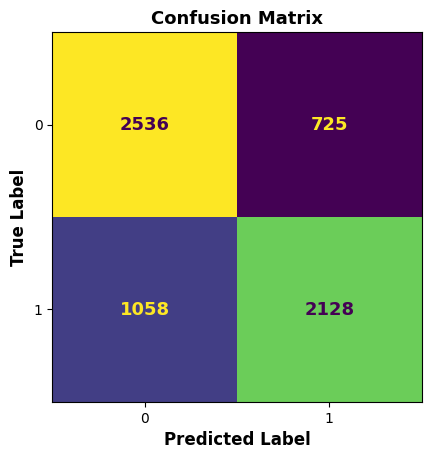

In [12]:
base_model_tabnet = TabNetClassifier(seed=42)

base_model_tabnet.fit(
    x_train_np, y_train_np,
    eval_set=[(x_train_np, y_train_np)],
    eval_metric=["accuracy"],           
    max_epochs=50
)

y_pred = base_model_tabnet.predict(x_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"TabNet Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_tabnet.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

#### **TabTransformer**

TabTransformer Accuracy: 0.7135

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.70      0.76      0.73      3261
 Cardio Risk       0.73      0.66      0.70      3186

    accuracy                           0.71      6447
   macro avg       0.72      0.71      0.71      6447
weighted avg       0.71      0.71      0.71      6447



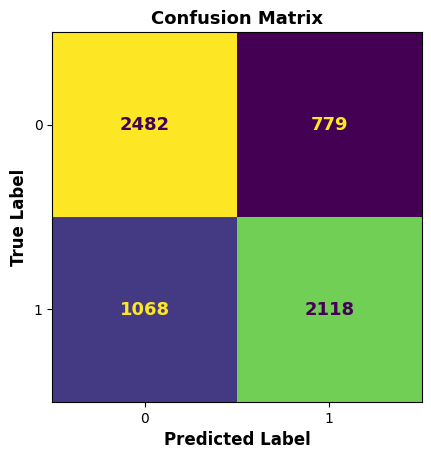

In [13]:
categorical_indices = [9, 10, 11, 12, 13, 14]  
continuous_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]     

class TabTransformerWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, categories, num_continuous, dim=32, depth=4, heads=4, dim_out=1, lr=0.001, epochs=5, batch_size=64):
        self.categories = categories
        self.num_continuous = num_continuous
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_out = dim_out
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = None

    def _initialize_model(self):
        """Initialize the TabTransformer model."""
        from tab_transformer_pytorch import TabTransformer
        self.model = TabTransformer(
            categories=self.categories,
            num_continuous=self.num_continuous,
            dim=self.dim,
            depth=self.depth,
            heads=self.heads,
            dim_out=self.dim_out
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self._initialize_model()

        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        dataset = torch.utils.data.TensorDataset(x_categ, x_cont, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for batch_x_categ, batch_x_cont, batch_y in dataloader:
                self.optimizer.zero_grad()
                preds = self.model(batch_x_categ, batch_x_cont).squeeze()
                loss = self.loss_fn(preds, batch_y)
                loss.backward()
                self.optimizer.step()

        # Define the `classes_` attribute
        self.classes_ = np.array([0, 1])  # Assuming binary classification
        return self

    def predict(self, X):
        X = np.asarray(X)

        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x_categ, x_cont).squeeze()
        return (torch.sigmoid(preds) > 0.5).cpu().numpy().astype(int)

    def predict_proba(self, X):
        X = np.asarray(X)

        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x_categ, x_cont).squeeze()
        return np.column_stack((1 - torch.sigmoid(preds).cpu().numpy(), torch.sigmoid(preds).cpu().numpy()))


base_model_tabtf = TabTransformerWrapper(
    categories=[2, 3, 3, 2, 2, 2],
    num_continuous=len(continuous_indices),
    dim=32,
    depth=4,
    heads=4,
    dim_out=1,
    epochs=50
)

base_model_tabtf.fit(x_train_np, y_train_np)

y_pred = base_model_tabtf.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"TabTransformer Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_tabtf.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

#### **Meta Model**

[LightGBM] [Info] Number of positive: 22570, number of negative: 22558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 45128, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500133 -> initscore=0.000532
[LightGBM] [Info] Start training from score 0.000532
Meta-Model Accuracy: 0.7245

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.71      0.76      0.74      3261
 Cardio Risk       0.74      0.69      0.71      3186

    accuracy                           0.72      6447
   macro avg       0.73      0.72      0.72      6447
weighted avg       0.73      0.72      0.72      6447



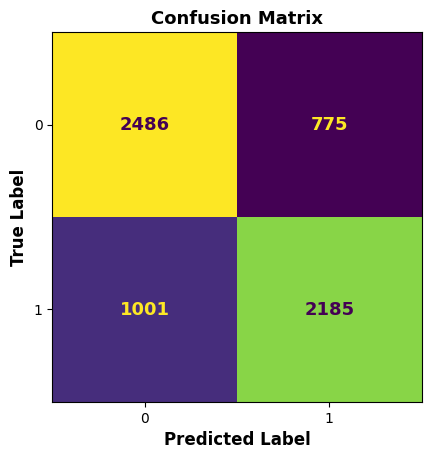

In [14]:
meta_model_lgb = lgb.LGBMClassifier()

meta_model_lgb.fit(x_train_np, y_train_np)

y_pred = meta_model_lgb.predict(x_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"Meta-Model Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=meta_model_lgb.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

#### **Stacking Model**

In [15]:
base_models = [
    ("ebc", base_model_ebm), ("ngb", base_model_ngb), ('snb', base_model_snb), 
    ('tabnet', base_model_tabnet), ('tabtf', base_model_tabtf)
]

In [16]:
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model_lgb
)

In [17]:
stacking_model.fit(x_train_np, y_train_np)

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5580 val_loss=0.0000 scale=2.0000 norm=3.7878
[iter 200] loss=0.5478 val_loss=0.0000 scale=2.0000 norm=3.8808
[iter 300] loss=0.5452 val_loss=0.0000 scale=1.0000 norm=1.9563
[iter 400] loss=0.5435 val_loss=0.0000 scale=1.0000 norm=1.9654
epoch 0  | loss: 0.63974 |  0:00:00s
epoch 1  | loss: 0.57615 |  0:00:01s
epoch 2  | loss: 0.56916 |  0:00:02s
epoch 3  | loss: 0.56561 |  0:00:03s
epoch 4  | loss: 0.56406 |  0:00:04s
epoch 5  | loss: 0.56071 |  0:00:05s
epoch 6  | loss: 0.55773 |  0:00:06s
epoch 7  | loss: 0.55701 |  0:00:07s
epoch 8  | loss: 0.55632 |  0:00:08s
epoch 9  | loss: 0.55468 |  0:00:09s
epoch 10 | loss: 0.55415 |  0:00:10s
epoch 11 | loss: 0.55395 |  0:00:11s
epoch 12 | loss: 0.55369 |  0:00:11s
epoch 13 | loss: 0.55254 |  0:00:12s
epoch 14 | loss: 0.55274 |  0:00:13s
epoch 15 | loss: 0.55256 |  0:00:14s
epoch 16 | loss: 0.55174 |  0:00:15s
epoch 17 | loss: 0.55165 |  0:00:16s
epoch 18 | loss:

KeyboardInterrupt: 

Stacking Model Accuracy: 0.7237

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.71      0.76      0.74      3261
 Cardio Risk       0.74      0.68      0.71      3186

    accuracy                           0.72      6447
   macro avg       0.72      0.72      0.72      6447
weighted avg       0.72      0.72      0.72      6447



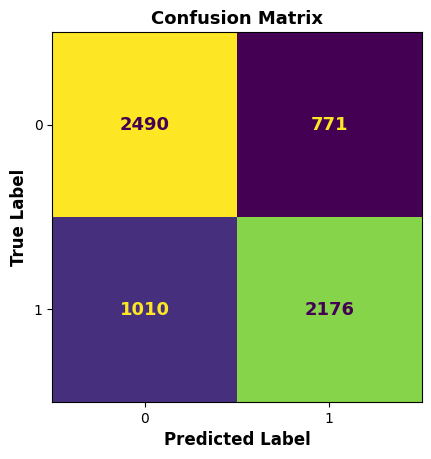

In [ ]:
y_pred = stacking_model.predict(x_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"Stacking Model Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()